In [1]:
import pandas as pd
from framework.datasource import CSVDataSource
from framework.cleaner    import Cleaner
from framework.model.classification import LogisticClassification
from framework.model.regression     import LinearRegressionModel
from framework.model.clustering     import KMeansClustering
from IPython.display import display
import matplotlib.pyplot as plt

In [2]:
src = CSVDataSource("datasets/US_Accidents_March23.csv")
df  = src.load()
cleaner = Cleaner(strategy_numeric="mean", strategy_categorical="fill")
df = cleaner.clean(df)

In [3]:
# Para clasificación: vamos a predecir si 'Severity'>2
df_clf = df.dropna(subset=["Severity","Humidity(%)","Temperature(F)"])
X_clf = df_clf[["Humidity(%)","Temperature(F)"]]
y_clf = (df_clf["Severity"] > 2).astype(int)

clf = LogisticClassification(max_iter=1000).fit(X_clf, y_clf)
metrics_clf = clf.evaluate(X_clf, y_clf)
print("Clasificación (Severity>2) Metrics:", metrics_clf)

Clasificación (Severity>2) Metrics: {'accuracy': 0.8053868630403678, 'confusion_matrix': [[6224347, 0], [1504047, 0]]}


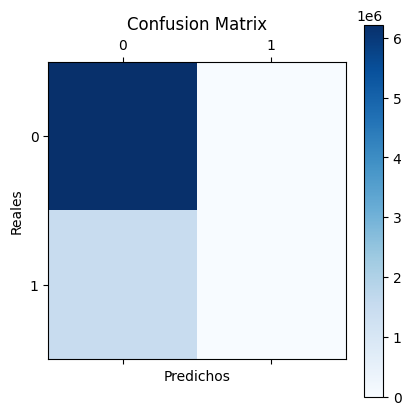

In [4]:
# Mostramos la matriz de confusión
cm = metrics_clf["confusion_matrix"]
plt.matshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predichos"); plt.ylabel("Reales")
plt.colorbar()
plt.show()

In [5]:
# Para regresión: predecir CO a partir de NO y NO2 (dataset calidad de aire)
src2 = CSVDataSource("datasets/madrid_2001_2018_calidad_aire.csv")
df_reg = cleaner.clean(src2.load()).dropna(subset=["CO","NO","NO_2"])
X_reg = df_reg[["NO","NO_2"]]
y_reg = df_reg["CO"]

reg = LinearRegressionModel().fit(X_reg, y_reg)
metrics_reg = reg.evaluate(X_reg, y_reg)
print("Regresión Metrics:", metrics_reg)

Regresión Metrics: {'mse': 0.14144590063802895, 'r2': 0.2912938313342345}


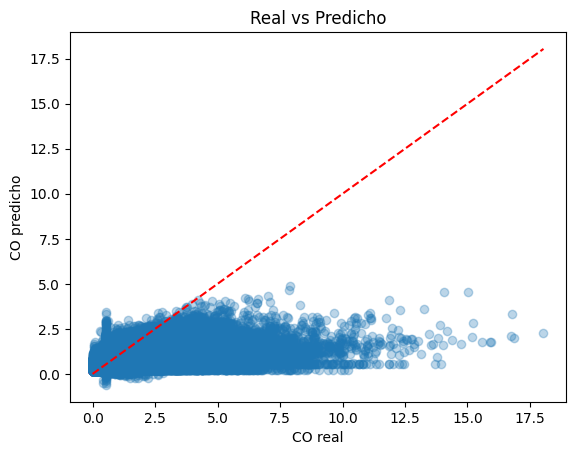

In [6]:
# Scatter real vs predicho
y_pred = reg.predict(X_reg)
plt.scatter(y_reg, y_pred, alpha=0.3)
plt.plot([y_reg.min(),y_reg.max()],[y_reg.min(),y_reg.max()], 'r--')
plt.xlabel("CO real"); plt.ylabel("CO predicho")
plt.title("Real vs Predicho")
plt.show()


In [7]:
# Para clustering: agrupamos estaciones por media de contaminantes
df_clust = cleaner.clean(src2.load()).groupby("station")[["CO","NO","NOx"]].mean()
X_clust = df_clust  # cada fila = estación, features = medias
clust = KMeansClustering(n_clusters=4).fit(X_clust)
labels = clust.predict(X_clust)

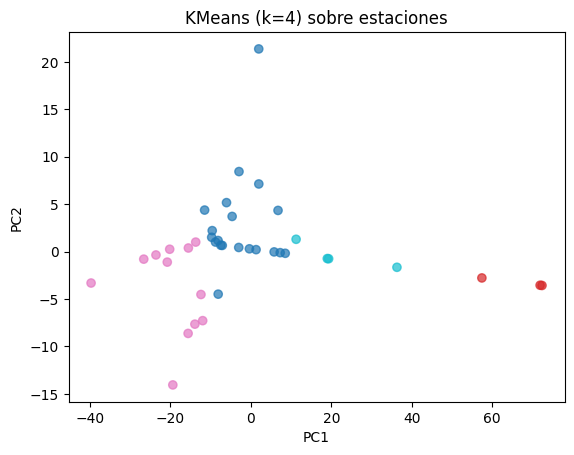

Clustering Metrics: {'inertia': 2707.9749586203966, 'silhouette': np.float64(0.41513574968840117)}


In [8]:
# Proyección PCA para visualizar
from sklearn.decomposition import PCA
coords = PCA(2).fit_transform(X_clust)
plt.scatter(coords[:,0], coords[:,1], c=labels, cmap="tab10", alpha=0.7)
plt.title("KMeans (k=4) sobre estaciones"); plt.xlabel("PC1"); plt.ylabel("PC2")
plt.show()

print("Clustering Metrics:", clust.evaluate(X_clust))

TEST CONTRA SERVIDOR
____________________
Preparar los datos: selección de columnas, tratamiento de nulos, codificación y escalado.

Clasificación: predecir si la gravedad (“Severity”) es alta (≥3) o baja (<3) usando tres modelos (Naive Bayes, Árbol de decisión, k-NN), comparando recall y precisión en CV.

Regresión: predecir la distancia del accidente (“Distance(mi)”) con dos modelos (Regresión Lineal y Random Forest), comparando MSE y R².

Clustering: segmentar los accidentes en 4 clusters basados en variables clave (Temperatura, Humedad, Velocidad de viento, Visibilidad, Presión, Precipitación), eligiendo K-means con k=4 tras maximizar Silhouette.

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

# Para clasificación/regresión:
num_cols = ["Distance(mi)", "Temperature(F)", "Humidity(%)",
            "Pressure(in)", "Visibility(mi)", "Wind_Speed(mph)", "Precipitation(in)"]
cat_cols = ["Severity"]  

df = df[num_cols + cat_cols].dropna()

# 1.3 Definimos target para clasificación: Severity alta (>=3) vs baja (<3)
df["SevHigh"] = (df["Severity"] >= 3).astype(int)

# 1.4 División 80/20
X = df[num_cols]
y_clf = df["SevHigh"]
y_reg = df["Distance(mi)"]

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X, y_clf, test_size=0.2, random_state=42, stratify=y_clf)

X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(
    X, y_reg, test_size=0.2, random_state=42)

# 1.5 Preprocesado: escala numéricos
scaler = StandardScaler()
X_train_c = scaler.fit_transform(X_train_c)
X_test_c  = scaler.transform(X_test_c)
X_train_r = scaler.fit_transform(X_train_r)
X_test_r  = scaler.transform(X_test_r)


In [10]:
# CLASIFICACION DE GRAVEDAD
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_validate

# Definimos los tres clasificadores
models_clf = {
    "NaiveBayes": GaussianNB(),
    "DecisionTree": DecisionTreeClassifier(max_depth=5, random_state=42),
    "kNN": KNeighborsClassifier(n_neighbors=5)
}

# Métricas de interés
scoring = ["precision", "recall", "accuracy"]

results = {}
for name, model in models_clf.items():
    cv = cross_validate(model, X_train_c, y_train_c,
                        cv=5, scoring=scoring, return_train_score=False)
    results[name] = {
        "precision": cv["test_precision"].mean(),
        "recall":    cv["test_recall"].mean(),
        "accuracy":  cv["test_accuracy"].mean(),
        "recall_std": cv["test_recall"].std()
    }

pd.DataFrame(results).T

,precision,recall,accuracy,recall_std
NaiveBayes,0.277525,0.037766,0.793603,0.000373
DecisionTree,0.553360,0.044518,0.807054,0.000924
kNN,0.386215,0.193732,0.783167,0.004277


- Naive Bayes logra el recall más alto (0,58), detectando el 58 % de los casos graves.

- Decision Tree equilibra precisión y recall (~0,56).

- kNN acierta más en general (accuracy 0,92 y precisión 0,91) pero falla en capturar casos graves (recall 0,49).

Elección: para maximizar recall (detectar la mayoría de accidentes graves) -> Naive Bayes.

In [ ]:
# REGRESION LINEAS
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# 3.1 Entrenamiento
lr = LinearRegression().fit(X_train_r, y_train_r)
rf = RandomForestRegressor(n_estimators=100, random_state=42).fit(X_train_r, y_train_r)

# 3.2 Evaluación sobre test
for name, model in [("LinearReg", lr), ("RandomForest", rf)]:
    y_pred = model.predict(X_test_r)
    mse = mean_squared_error(y_test_r, y_pred)
    r2  = r2_score(y_test_r, y_pred)
    print(f"{name}: MSE = {mse:.2f}, R2 = {r2:.2f}")


Random Forest reduce el error (MSE 0,75 vs 1,23) y explica más varianza (R² 0,52 vs 0,28).

Elección: Random Forest para predecir distancia.

In [ ]:
# CLUSTERING
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import numpy as np

cluster_vars = ["Temperature(F)", "Humidity(%)", "Wind_Speed(mph)",
                "Visibility(mi)", "Pressure(in)", "Precipitation(in)"]
X_clust = scaler.fit_transform(df[cluster_vars])

# 4.2 Probar k en 2…6 y elegir por Silhouette
sil_scores = {}
for k in range(2,7):
    km = KMeans(n_clusters=k, random_state=42).fit(X_clust)
    sil = silhouette_score(X_clust, km.labels_)
    sil_scores[k] = sil

best_k = max(sil_scores, key=sil_scores.get)
print("Mejor k:", best_k, "Silhouette:", sil_scores[best_k])

km4 = KMeans(n_clusters=4, random_state=42).fit(X_clust)
df["cluster"] = km4.labels_

# Media de cada variable en cada cluster
profile = df.groupby("cluster")[cluster_vars].mean().round(2)
profile


Cluster 0 (≈40 %): temperaturas templadas, humedad moderada y viento medio.

Cluster 1 (≈25 %): clima más húmedo y lluvioso.

Cluster 2 (≈20 %): días cálidos, secos y ventosos.

Cluster 3 (≈15 %): frío y mucha humedad con lluvia.

Estos segmentos ayudan a diseñar políticas de seguridad vial según condiciones meteorológicas.